In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from  sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv(r'data/indego/bikewise.csv')

In [3]:
df.head()

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,bike_type,round_trip_rate,trips_to_3000,trips_from_3000,age,use_rate,avg_speed,retired
0,2472.0,51496,19.905682,2587,2906.614566,1.123546,2019-08-22 16:41:00,2015-06-29 08:27:00,standard,0.072284,21.0,0.0,2182094,2.359935,3.386610,1.0
1,2473.0,54273,20.628278,2631,3069.109171,1.166518,2019-08-29 15:53:00,2015-04-27 15:20:00,standard,0.091600,25.0,1.0,2282433,2.377857,3.392968,1.0
2,2474.0,35313,18.174472,1943,2314.839799,1.191374,2019-05-08 07:40:00,2015-09-16 12:29:00,standard,0.081832,16.0,0.0,1914911,1.844107,3.933123,1.0
3,2475.0,46506,21.313474,2182,2674.234933,1.225589,2019-05-02 19:51:00,2015-08-04 10:21:00,standard,0.095784,11.0,1.0,1969050,2.361850,3.450181,1.0
4,2476.0,58911,21.175773,2782,3598.179104,1.293379,2020-06-21 11:36:00,2015-05-09 17:56:00,standard,0.088785,31.0,0.0,2692420,2.188032,3.664693,0.0


In [4]:
len(df)

1967

In [5]:
len(df[df['retired'] == 1])

451

In [6]:
df.tail()

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,bike_type,round_trip_rate,trips_to_3000,trips_from_3000,age,use_rate,avg_speed,retired
1962,19971.0,5025,32.419355,155,292.537050,1.887336,2020-06-25 21:04:00,2020-05-09 14:21:00,electric,0.232258,0.0,0.0,68083,7.380697,3.492980,0.0
1963,19977.0,5239,44.398305,118,191.077182,1.619298,2020-06-30 21:23:00,2020-06-05 10:57:00,electric,0.161017,0.0,0.0,36626,14.304046,2.188324,0.0
1964,20265.0,5164,30.922156,167,186.754554,1.118291,2019-10-05 16:46:46,2019-08-24 19:41:00,electric,0.107784,3.0,0.0,60305,8.563137,2.169883,1.0
1965,26012.0,332,27.666667,12,23.367884,1.947324,2015-04-30 15:33:00,2015-04-25 13:36:00,standard,0.166667,0.0,0.0,7317,4.537379,4.223112,1.0
1966,55195.0,4353,25.161850,173,272.236787,1.573623,2016-10-22 15:35:00,2016-09-09 15:08:00,standard,0.057803,2.0,0.0,61947,7.026975,3.752402,1.0


## Model Selection

In [7]:
# Define a feature to report performance indicators

def score(algo):
    # Fit the model and make predictions
    algo.fit(X_train, y_train)
    preds = algo.predict(X_test)
    probs = algo.predict_proba(X_test)[:, 1]
    
    # Create a Confusion Matrix
    matrix = confusion_matrix(y_test, preds)
    cm = pd.DataFrame(
    confusion_matrix(y_test, preds),
    columns=['Predicted Not Retired', 'Predicted Retired'],
    index=['True Not Retired', 'True Retired'])
    print('-----Confusion Matrix-----')
    print(cm, '\n')
    
    # Print the metrics
    print('Accuracy Score: {}'.format(accuracy_score(y_test, preds)))
    print('Recall Score: {}'.format(recall_score(y_test, preds)))
    print('Precision Score: {}'.format(precision_score(y_test, preds)))
    print('F-1 Score: {}'.format(f1_score(y_test, preds)))
    print('Area under the ROC curve: {}'.format(roc_auc_score(y_test, probs)))
    
    #Print the ROC curve
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    fig = plt.figure(figsize = (6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [8]:
from sklearn.dummy import DummyClassifier

In [9]:
index = df[df['bike_type'] == 'electric'].index
df.loc[index, 'electric'] =1
df.loc[:, 'electric'] =df.loc[: 'electric'].fillna(0)
df.drop('bike_type', axis=1, inplace=True)

In [10]:
X = df.drop(['bike_id', 'most_recent_trip', 'first_trip', 'trips_from_3000', 'retired'], axis=1)
y = df['retired']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

### Dummy Classifier Baseline

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    386                  0
True Retired                        106                  0 

Accuracy Score: 0.7845528455284553
Recall Score: 0.0
Precision Score: 0.0
F-1 Score: 0.0
Area under the ROC curve: 0.5


/home/owen/bin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


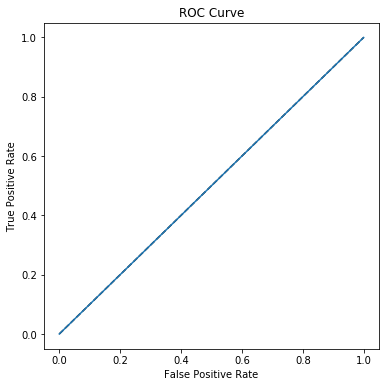

In [12]:
dummy = DummyClassifier(strategy = 'most_frequent')
score(dummy)

In [13]:
# Create a dataframe to keep track of feature importances
importances = pd.DataFrame(index=[X.columns])

### Decision Tree

Text(0.5, 1.0, 'Max Features')

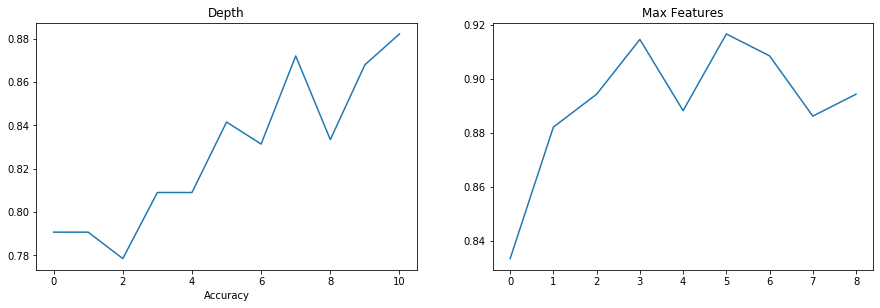

In [14]:
depth_scores = []
for depth in range(1,12):
    # Initialize and train our tree.
    decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=1,
        max_depth=depth,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )
    decision_tree.fit(X_train, y_train)
    depth_scores.append(decision_tree.score(X_test, y_test))
    
    
features_scores = [] 
for feature in range(1,10):
    # Initialize and train our tree.
    decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=feature,
        max_depth=9,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )
    decision_tree.fit(X_train, y_train)
    features_scores.append(decision_tree.score(X_test, y_test))
    
plt.figure(figsize=(15,10))    
plt.subplot(2,2,1)
plt.plot(depth_scores)
plt.title('Depth')
plt.xlabel('Accuracy')

plt.subplot(2,2,2)
plt.plot(features_scores)
plt.title('Max Features')
#print('Train score results: ', decision_tree.score(X_train, y_train), '\n', '=' * 22)
#print ('Test score results: ', decision_tree.score(X_test, y_test))

In [15]:
 decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features=4,
        max_depth=10,
        random_state = 4123 # keep the random state the same to best see how my changes impact the model
    )

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    365                 21
True Retired                         33                 73 

Accuracy Score: 0.8902439024390244
Recall Score: 0.6886792452830188
Precision Score: 0.776595744680851
F-1 Score: 0.73
Area under the ROC curve: 0.8583194838205105


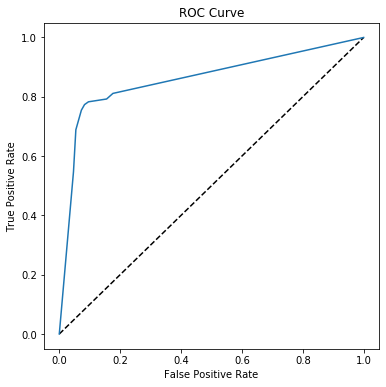

In [16]:
score(decision_tree)

In [17]:
# Get the feature importance
out =decision_tree.tree_.compute_feature_importances(normalize=False)

decision_tree_importances = pd.DataFrame(data=out
                                         , index=[X.columns], columns=['decision_tree'])

importances = importances.join(decision_tree_importances)

decision_tree_importances

,decision_tree
total_time,0.023559
mean_time,0.024213
trips,0.086772
total_distance,0.023237
mean_distance,0.100817
round_trip_rate,0.070273
trips_to_3000,0.032682
age,0.127000
use_rate,0.079994
avg_speed,0.086195


### Random Forest

In [18]:
rfc = ensemble.RandomForestClassifier(
    n_estimators=1000
    , max_features=4
    ,max_depth=10)

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    376                 10
True Retired                         22                 84 

Accuracy Score: 0.9349593495934959
Recall Score: 0.7924528301886793
Precision Score: 0.8936170212765957
F-1 Score: 0.8400000000000001
Area under the ROC curve: 0.9815720011731353


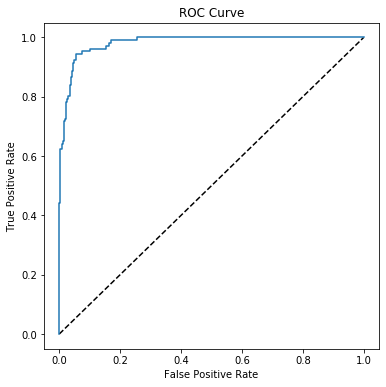

In [19]:
score(rfc)

In [20]:


out = rfc.feature_importances_
random_forest_importances = pd.DataFrame(data=out
                                         , index=[X.columns], columns=['random_forest'])
importances = importances.join(random_forest_importances)

random_forest_importances

,random_forest
total_time,0.052194
mean_time,0.057851
trips,0.072606
total_distance,0.082378
mean_distance,0.107793
round_trip_rate,0.104646
trips_to_3000,0.082589
age,0.198330
use_rate,0.108362
avg_speed,0.094699


### KNN

In [21]:
train_scores=[]
test_scores=[]
for val in np.arange(1,30):
    knn = neighbors.KNeighborsClassifier(n_neighbors=val)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    train_scores.append(train_score)
    
    test_score= knn.score(X_test, y_test)
    test_scores.append(test_score)


In [22]:
weighted_train_scores=[]
weighted_test_scores=[]
for val in np.arange(1,30):
    knn = neighbors.KNeighborsClassifier(n_neighbors=val, weights='distance')
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    weighted_train_scores.append(train_score)
    
    test_score= knn.score(X_test, y_test)
    weighted_test_scores.append(test_score)


Text(0.5, 1.0, 'With Weighting')

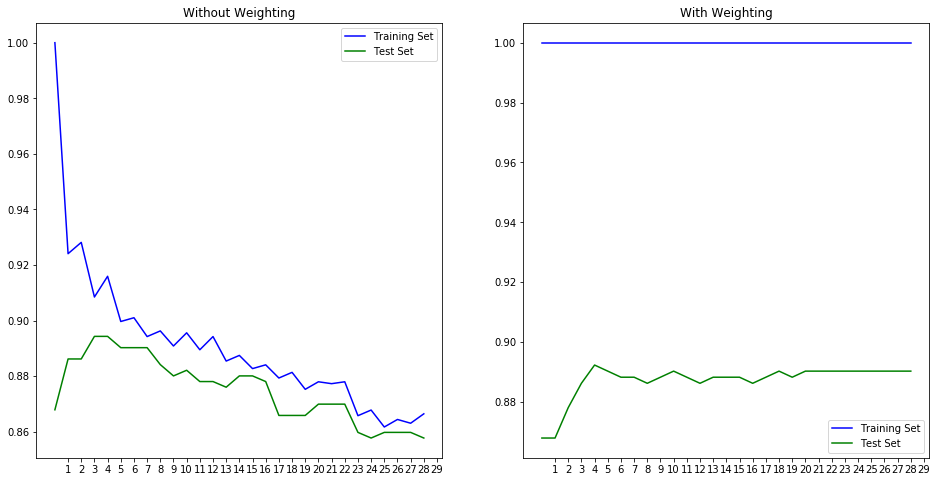

In [23]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(train_scores, color='blue', label='Training Set')
plt.plot(test_scores, color='green', label='Test Set')
plt.xticks(np.arange(1,30))
plt.legend()
plt.title('Without Weighting')


plt.subplot(1,2,2)
plt.plot(weighted_train_scores, color='blue', label='Training Set')
plt.plot(weighted_test_scores, color='green', label='Test Set')
plt.xticks(np.arange(1,30))
plt.legend()
plt.title('With Weighting')


-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    373                 13
True Retired                         46                 60 

Accuracy Score: 0.8800813008130082
Recall Score: 0.5660377358490566
Precision Score: 0.821917808219178
F-1 Score: 0.6703910614525139
Area under the ROC curve: 0.9147643953465636


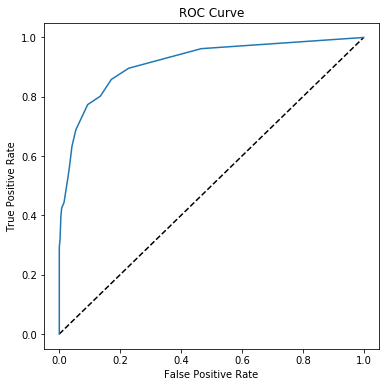

In [24]:
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
score(knn)

### Logistic Regression

In [25]:
lrc = LogisticRegression(solver='lbfgs') 

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    378                  8
True Retired                         87                 19 

Accuracy Score: 0.806910569105691
Recall Score: 0.1792452830188679
Precision Score: 0.7037037037037037
F-1 Score: 0.2857142857142857
Area under the ROC curve: 0.7296656564669078


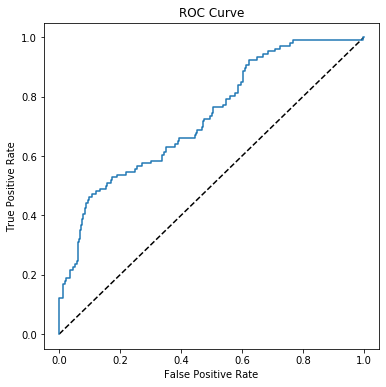

In [26]:
score(lrc)

### SVC

In [27]:
scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.25, random_state=1312)



-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    383                  3
True Retired                         67                 39 

Accuracy Score: 0.8577235772357723
Recall Score: 0.36792452830188677
Precision Score: 0.9285714285714286
F-1 Score: 0.527027027027027
Area under the ROC curve: 0.8783605435526445


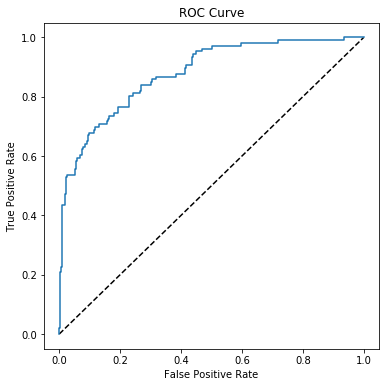

In [28]:
svc = SVC(kernel='linear', probability=True)
score(svc)

In [29]:
out = svc.coef_

pd.DataFrame(data=out.reshape(-1,1), index=[X.columns])

,0
total_time,0.596792
mean_time,-0.050568
trips,-3.820109
total_distance,3.117885
mean_distance,-0.350613
round_trip_rate,-0.321997
trips_to_3000,-0.339637
age,-0.725084
use_rate,0.503527
avg_speed,0.514907


### AdaBoost

In [30]:
ada = ensemble.AdaBoostClassifier(
     n_estimators=1000
    , learning_rate=1.0)

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    373                 13
True Retired                         17                 89 

Accuracy Score: 0.9390243902439024
Recall Score: 0.839622641509434
Precision Score: 0.8725490196078431
F-1 Score: 0.8557692307692308
Area under the ROC curve: 0.9751686381855509


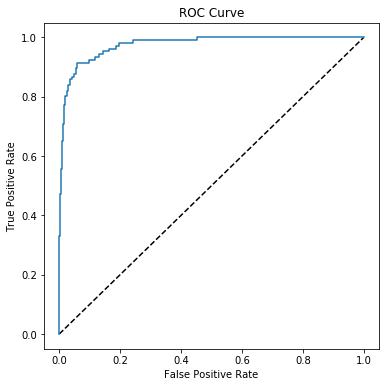

In [31]:
score(ada)

In [32]:
out = ada.feature_importances_

ada_feature_importances = pd.DataFrame(data=out, columns=['AdaBoost'], index=[X.columns])

importances = importances.join(ada_feature_importances)

ada_feature_importances.sort_values()

,AdaBoost
total_time,0.091
mean_time,0.099
trips,0.080
total_distance,0.054
mean_distance,0.092
round_trip_rate,0.067
trips_to_3000,0.045
age,0.273
use_rate,0.088
avg_speed,0.079


In [33]:
xgb = XGBClassifier(
    n_estimators=1000
    , learning_rate=1.0)

-----Confusion Matrix-----
                  Predicted Not Retired  Predicted Retired
True Not Retired                    375                 11
True Retired                         18                 88 

Accuracy Score: 0.9410569105691057
Recall Score: 0.8301886792452831
Precision Score: 0.8888888888888888
F-1 Score: 0.8585365853658536
Area under the ROC curve: 0.9841871150650112


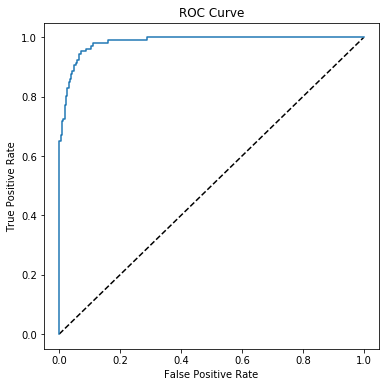

In [34]:
score(xgb)

In [53]:
out = xgb.feature_importances_

xgb_feature_importances = pd.DataFrame(data=out, columns =['XGBoost'], index=[X.columns])

#importances = importances.join(xgb_feature_importances)

xgb_feature_importances.sort_values(by='XGBoost')

,XGBoost
total_time,0.034861
mean_time,0.038794
avg_speed,0.053497
use_rate,0.054775
trips,0.061634
round_trip_rate,0.069925
electric,0.105376
total_distance,0.105513
trips_to_3000,0.129967
mean_distance,0.169650


In [36]:
importances['sum'] = importances.sum(axis=1)
importances = importances.sort_values(by='sum', ascending=False)
importances.drop('sum', axis=1, inplace=True)

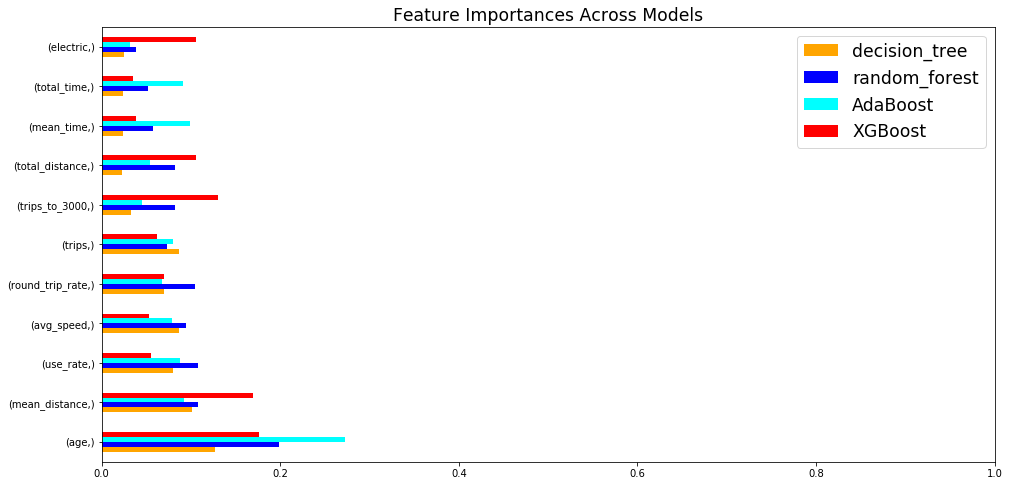

In [66]:
fig, ax = plt.subplots(figsize=(16,8))
importances.plot(kind='barh', stacked=False, color=['orange', 'blue', 'cyan', 'red'], ax=ax)
plt.title('Feature Importances Across Models', size='xx-large')
plt.xlim(0,1)
plt.legend(fontsize='xx-large')
plt.show()

In [58]:
# Use cross validation to confirm the three best solvers. AdaBoost, RandomForest, and XGBoost 
# all performed significantly better than the others and similarly to eachother.

solvers = {ada : 'AdaBoost Classifier' ,rfc : 'Random Forest Classifier',  xgb : 'XGBoost Classifier'}

for algo, name in solvers.items():
    scores = cross_val_score(algo, X_train, y_train, cv = 5)
    print('5 fold cross validation score mean for {}:  {}'.format(name, scores.mean()))

5 fold cross validation score mean for AdaBoost Classifier:  0.9220338983050848
5 fold cross validation score mean for Random Forest Classifier:  0.928135593220339
5 fold cross validation score mean for XGBoost Classifier:  0.936949152542373


In [ ]:
# None of them perform much differently than they did before. XGBoost is still the best. I will tune it with
# grid search.